In [1]:
import numpy as np
import time

import h5py, os, time, math
from scipy.special import erf
from numba import cuda
print(cuda.gpus)

import matplotlib.pyplot as plt

<Managed Device 0>


In [2]:
# x-ray parameters and constants
c = 299792458								# m/s
hbar = 6.582119514e-16						# eV*s
r = 4.										# source to detector distance (m)
depthabs = 20e-6							# samnple absorption depth (m)

# k-alpha 1, k-alpha 2, k-beta 1,3
evs1 = 6403.8; As1 = 100; ws1 = 2.55; dts1 = 4e-15/ws1; ks1 = evs1/hbar/c
evs2 = 6390.8; As2 = 50; ws2 = 3.00; dts2 = 4e-15/ws2; ks2 = evs2/hbar/c
evs3 = 7058.0; As3 = 17; ws3 = 3.59; dts3 = 4e-15/ws3; ks3 = evs3/hbar/c

# convert information to arrays
evlist = np.asarray([evs1, evs2, evs3]) 	# photon energies
plist = np.asarray([As1, As2, As3])
# plist = np.asarray([1,0,0])					# if only one color
plist = plist/plist.sum() 					# probability densities
omglist = evlist/hbar						# angular frequencies
dtslist = np.asarray([dts1,dts2,dts3])

# Focal spot information (in sample coordinate)
spotpos = 0e-6								# focal spot average position
spotsig = 2e-6								# focal spot sigma
spotsep = 0									# focal spot separation (0 if single spot)

# Detector pixel information
detsize = 5e-3								# detector size (m)
pxlsize = 50e-6								# single pixel size (m)
Npxl = int(detsize/pxlsize + 1)				# number of pixels in each axis
xdet = np.linspace(0,detsize,int(Npxl)) - detsize/2
ydet = xdet.copy()


In [3]:
##########
# x-ray temporal structure
##########
def delta(tpulse,Natom):
	tlit = np.zeros(Natom)
	I_ratio = 1
	non_linearity = 1e6
	return tlit, I_ratio, non_linearity

def square(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	tlit = np.random.random(Natom)*tpulse
	I_ratio = 1
	non_linearity = 1/tpulse
	return tlit, I_ratio, non_linearity

def squaremono(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	tsamp = np.arange(1e7)/1e7 *(tpulse+20)						# sampling range
	tsamp = tsamp-tsamp.mean()									# shifted sampling range (centering at t=0)
	psamp = -erf((tsamp-tpulse/2)/(2**0.5 * 4.0/2.36)) + erf((tsamp+tpulse/2)/(2**0.5 * 4.0/2.36))
	psamp = psamp/psamp.sum()
	tlit = np.random.choice(tsamp,p=psamp,size=Natom)
	I_ratio = 1
	non_linearity = np.sum(psamp**2)
	return tlit, I_ratio, non_linearity

def Gaus(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	width = tpulse/2.36
	tlit = np.random.normal(0,width,Natom)
	# peak pulse intensity / average pulse intensity for non-linear effect observation
	tt = np.linspace(-tpulse/2-width,tpulse/2+width,int(tpulse*10000))
	I_t = np.exp(-tt**2/(2*width**2))
	I_ratio = I_t.max()/I_t.mean()
	non_linearity = 1/(2*np.sqrt(np.pi)*width)
	return tlit, I_ratio, non_linearity

def Gausmono(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	width = (tpulse**2+4.0**2)**0.5/2.36		# assume super short pulse through 2 bounce C111 stretches to 4fs
	tlit = np.random.normal(0,width,Natom)
	# peak pulse intensity / average pulse intensity for non-linear effect observation
	tt = np.linspace(-tpulse/2-width,tpulse/2+width,int(tpulse*10000))
	I_t = np.exp(-tt**2/(2*width**2))
	I_ratio = I_t.max()/I_t.mean()
	non_linearity = 1/(2*np.sqrt(np.pi)*width)
	return tlit, I_ratio, non_linearity

def SASE(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	tcs = np.random.random(2000) * 200. - 100.						# uniformly sampled pink beam SASE spike positions
	Amps = np.random.random(2000)
	Amps = Amps * np.exp(-(tcs**2/(2*(tpulse/2.36)**2))**2)
	Amps = Amps/Amps.sum()
	index = (Amps>=1e-4)				# mask for pulse duration window
	numSpike = index.sum()
	if numSpike==0:
		tcs = np.zeros(1)
		Amps = np.ones(1)
		index = np.asarray([True])
		numSpike = 1

	tcs = tcs[index]; Amps = Amps[index]
	widths = np.random.uniform(low=0.08,high=0.12,size=numSpike)
	Ns = np.rint(Amps*Natom)
	if Ns.sum() < Natom:
		Ndiff = int(Natom - Ns.sum())
		inds = np.random.choice(np.arange(numSpike),size=Ndiff)
		for ind in inds:
			Ns[ind] += 1

	if Ns.sum() > Natom:
		while Ns.sum() != Natom:
			Ns[np.random.choice(np.argwhere(Ns>=1)[:,0])] -= 1
	Ns = Ns.astype(np.int64)

	tlit = []
	for i in range(numSpike):
		tlit_piece = np.random.normal(tcs[i],widths[i],Ns[i])
		tlit.append(tlit_piece)
	tlit = np.concatenate(tlit); tlit = tlit-tlit.mean()

	nbins = int((tlit.max()-tlit.min())*20)

	# peak pulse intensity / average pulse intensity for non-linear effect observation
	tt = np.linspace(-tpulse,tpulse,nbins)
	I_t = np.zeros_like(tt)
	for j in range(numSpike):
		I_t += Amps[j] * np.exp(-(tt-tcs[j])**2/(2*widths[j]**2))
	I_ratio = I_t.max()/I_t.mean()
	non_linearity = np.sum((I_t/I_t.sum())**2)
	return tlit, I_ratio, non_linearity

def SASEmono(tpulse,Natom):
	if tpulse == 0: tpulse += 1e-3
	tcs = np.random.random(150) * 1000							# randomly throw in 150 centers over 1ps
	tcs = tcs[(tcs>5)&(tcs<5+tpulse)]							# crop window to get actual centers of Gaussian
	try: tcs[0]
	except: tcs = np.random.random(1)*tpulse+5.					# if none, make one
	numGaus = int(tcs.size)

	widths = np.random.uniform(low=1.65,high=1.75,size=numGaus)	# rms widths assuming mono stretches to 4fs FW (1.7fs rms)
	Amps = np.random.random(numGaus); Amps = Amps/Amps.sum()	# amplitudes of Gaussian
	Ns = np.rint(Amps * Natom)									# number in each Gaussian
	# if total number of atoms in each slice does not equal to Natom, randomly fill in the missing ones
	if Ns.sum() < Natom:
		Ndiff = int(Natom - Ns.sum())
		inds = np.random.choice(np.arange(numGaus),size=Ndiff)
		for ind in inds:
			Ns[ind] += 1
	if Ns.sum() > Natom:
		while Ns.sum() != Natom:
			indlist = np.arange(numGaus)
			plist = Ns/Ns.sum()
			ind = np.random.choice(indlist,p=plist)
			Ns[ind] -= 1							
	Ns = Ns.astype(np.int64)
	tlit = []
	# randomly sample light up time for each atom
	for i in range(numGaus):
		try:
			tlit_piece = np.random.normal(tcs[i],widths[i],Ns[i])
			tlit.append(tlit_piece)
		except:
			print(i)
			print(tcs[i])
			print(widths[i])
			print(Ns[i])
	tlit = np.concatenate(tlit); tlit = tlit-tlit.mean()

	# peak pulse intensity / average pulse intensity for non-linear effect observation
	tt = np.linspace(0,tpulse+10,int(tpulse*100000))
	I_t = np.zeros_like(tt)
	for j in range(numGaus):
		I_t += Amps[j] * np.exp(-(tt-tcs[j])**2/(2*widths[j]**2))
	I_ratio = I_t.max()/I_t.mean()
	non_linearity = np.sum((I_t/I_t.sum())**2)
	return tlit, I_ratio, non_linearity

##########
# source parameter generation
##########
def sframe(tpulse,Natom,dsamp,tlit):
	radius = np.random.normal(spotpos,spotsig,Natom)		# radial positions (Gaussian)
	ths = 2 * np.pi * np.random.random(Natom)				# angular positions (Uniform)
	phs = 2 * np.pi * np.random.random(Natom)				# initial phases	(Uniform)
	pols = 2 * np.pi * np.random.random(Natom)				# light polarization (Uniform)
	omgs = np.random.choice(omglist,p=plist,size=Natom)		# angular frequencies (Sampled)	

	ks = omgs/c 											# wavenumbers
	taus = np.zeros_like(omgs)								# lifetimes
	taus[omgs==omglist[0]] = dts1
	taus[omgs==omglist[1]] = dts2
	taus[omgs==omglist[2]] = dts3

	# source position (in sample coordinate)
	xsource = radius * np.cos(ths)
	ysource = radius * np.sin(ths) * np.sqrt(2)
	K = 1/(1-np.exp(-dsamp*np.sqrt(2)/depthabs))			# coefficient for absorption depth calculation
	cdf = np.random.sample(Natom)							# cumulative probability (Uniform)
	zsource = -depthabs * np.log(1-cdf/K)					# depth in sample (x-ray direction)
	#zsource = np.random.random(Natom)*dsamp*np.sqrt(2)		# depth ignoring absorption depth

	ysource[:int(Natom/2)] = ysource[:int(Natom/2)] + spotsep/2		# offset focal spots
	ysource[int(Natom/2):] = ysource[int(Natom/2):] - spotsep/2

	# source position (in lab coordinate)
	xs = xsource
	ys = ysource/np.sqrt(2) - zsource
	zs = -ysource/np.sqrt(2)
	# Actual light-up time including path-length difference (t=0 when incident x-ray hits origin in lab coordinate)
	ts = tlit*1e-15 - ys/c
	return xs,ys,zs,ts,phs,omgs,ks,taus,pols

##########
# memory transfer
##########
def strans(xs,ys,zs,ts,phs,omgs,ks,taus,pols,dtslist,xdet,ydet,r):
	''' 
	xs, ys, zs: source positions, shape(N)
	ts: time of emission, shape(N)
	phs: initial phase, shape(N)
	omgs: angular frequencies, shape(N)
	ks: wave vectors, shape(N)
	taus: spontaneous emission lifetime, shape(N)
	pols: polarization angle, shape(N)
	dtslist: spontaneous emission lifetime for each emission line, shape(3)
	xdeg, ydet: detector pixel position, shape(Npxl)
	r: distance betweeen source and detector in lab frame, shape(1)
	'''
	xsg = cuda.to_device(xs)
	ysg = cuda.to_device(ys)
	zsg = cuda.to_device(zs)
	tsg = cuda.to_device(ts)
	phsg = cuda.to_device(phs)
	omgsg = cuda.to_device(omgs)
	ksg = cuda.to_device(ks)
	tausg = cuda.to_device(taus)
	dtslistg = cuda.to_device(dtslist)

	xdetg = cuda.to_device(xdet)
	ydetg = cuda.to_device(ydet)
	rg = cuda.to_device(r)

##########
# spatial component calculation
##########
dtype1 = 'float64[:,:,:],complex128[:,:,:],float64[:,:,:],'
dtype2 = 'float64[:],float64[:],float64[:],float64[:],float64[:],float64[:],'
dtype3 = 'float64[:],float64[:],float64'
@cuda.jit('void('+dtype1+dtype2+dtype3+')')
def spatial(rs,Fs,ta,
    xs,ys,zs,ks,ts,phs,
    xdet,ydet,r):
    i, j = cuda.grid(2)
    Nx = xdet.size; Ny = ydet.size; Natom = xs.size
    # loop through pixels
    if i<Nx and j<Ny:
    	# loop through atoms
        for natom in range(Natom):
        	# distance between atom and pixel
            rs[natom,i,j] = math.sqrt(
                (xs[natom]-xdet[i])**2+(ys[natom]-ydet[j])**2+(zs[natom]-r)**2
                )
            # spatial component of the spherical wave: 1/r*exp[i(kr+phi)]
            Fs[natom,i,j] = complex(1/rs[natom,i,j])*(
                math.cos(ks[natom]*rs[natom,i,j]+phs[natom])+1j*math.sin(ks[natom]*rs[natom,i,j]+phs[natom])
                )
            # wavefront time of arrival = time of emission + r/c
            ta[natom,i,j] = ts[natom] + rs[natom,i,j]/299792458.

##########
# temporal component calculation
##########
# phase of all atoms
@cuda.jit('void(complex128[:,:],float64[:],float64[:])')
def temporal(T2,omgs,taxis):
	nslice,natom = cuda.grid(2)
	Nslice, Natom = T2.shape
	if nslice<Nslice and natom<Natom:
		T2[nslice,natom] = math.cos(omgs[natom]*taxis[nslice])+1j*math.sin(omgs[natom]*taxis[nslice])

##########
# speckle pattern simulation
##########
# field strength per time slice, reinitialize if changing parameters
dtype1 = 'complex128[:,:,:],complex128[:,:,:],complex128[:,:,:],complex128[:,:,:],'
dtype2 = 'float64,complex128[:],float64[:,:,:],float64[:],float64[:],float64[:],float64[:]'
@cuda.jit('void('+dtype1+dtype2+')')
def getslice(E1slice,E2slice,E3slice,Fs,
    t,T2slice,ta,taus,polx,poly,dtslist):
    i,j = cuda.grid(2)
    Natom,Nx,Ny = Fs.shape
    # loop through pixels
    if i<Nx and j<Ny:
    	# loop through atoms
        for natom in range(Natom):
        	# check if wavefront has arrived
            if t>=ta[natom,i,j] and t<ta[natom,i,j]+8*taus[natom]:
            	# if arrived, calculate time-dependent amplitude
                A = complex(math.exp(-(t-ta[natom,i,j])/taus[natom]))
                # check color and add to field container accordingly
                if taus[natom] == dtslist[0]:
                    E1slice[i,j,0] += A * T2slice[natom] * Fs[natom,i,j] * polx[natom]
                    E1slice[i,j,1] += A * T2slice[natom] * Fs[natom,i,j] * poly[natom]
                if taus[natom] == dtslist[1]:
                    E2slice[i,j,0] += A * T2slice[natom] * Fs[natom,i,j] * polx[natom]
                    E2slice[i,j,1] += A * T2slice[natom] * Fs[natom,i,j] * poly[natom]
                if taus[natom] == dtslist[2]:
                    E3slice[i,j,0] += A * T2slice[natom] * Fs[natom,i,j] * polx[natom]
                    E3slice[i,j,1] += A * T2slice[natom] * Fs[natom,i,j] * poly[natom]

# intensity per time slice (only used for comparing non-linear effect and speckle contrast)
@cuda.jit('void(float64[:,:,:],complex128[:,:,:,:],complex128[:,:,:,:],complex128[:,:,:,:])')
def get_imgs(Imgs,Es1,Es2,Es3):
	i,j = cuda.grid(2)
	Nslice,Nx,Ny,_ = Es1.shape
	if i<Nx and j<Ny:
		for nslice in range(Nslice):
			# adding intensities in two polarizations in each time slice
			Imgs[nslice,i,j] += abs(Es1[nslice,i,j,0])**2+abs(Es2[nslice,i,j,0])**2+abs(Es3[nslice,i,j,0])**2
			Imgs[nslice,i,j] += abs(Es1[nslice,i,j,1])**2+abs(Es2[nslice,i,j,1])**2+abs(Es3[nslice,i,j,1])**2

# overall intensity (image), reinitialize if changing parameters
@cuda.jit('void(float64[:,:],complex128[:,:,:,:],complex128[:,:,:,:],complex128[:,:,:,:])')
def get_img(Img,Es1,Es2,Es3):
	i,j = cuda.grid(2)
	Nslice,Nx,Ny,_ = Es1.shape
	if i<Nx and j<Ny:
		for nslice in range(Nslice):
			# adding intensities in two polarizations
			Img[i,j] += abs(Es1[nslice,i,j,0])**2+abs(Es2[nslice,i,j,0])**2+abs(Es3[nslice,i,j,0])**2
			Img[i,j] += abs(Es1[nslice,i,j,1])**2+abs(Es2[nslice,i,j,1])**2+abs(Es3[nslice,i,j,1])**2


In [4]:
# simulation variables
tpulse = 100.			# pulse duration (fs)
Natom = 1000			# number of atoms (photons)
dsamp = 10 * 1e-9 		# sample thickness (m)
Tmodel = 'Gaus'		# incident pulse time structure

if Tmodel == 'Delta':       tlit, _, _ = delta(tpulse, Natom); tpulse = 0.
if Tmodel == 'Square':		tlit, _, _ = square(tpulse, Natom)
if Tmodel == 'Square_mono': tlit, _, _ = squaremono(tpulse,Natom)
if Tmodel == 'Gaus':		tlit, _, _ = Gaus(tpulse,Natom)
if Tmodel == 'Gaus_mono':	tlit, _, _ = Gausmono(tpulse,Natom)
if Tmodel == 'SASE':		tlit, _, _ = SASE(tpulse,Natom)
if Tmodel == 'SASE_mono':	tlit, _, _ = SASEmono(tpulse,Natom)

tic = time.time()

# generate source information and feed to the gpu
(xs,ys,zs,ts,phs,omgs,ks,taus,pols) = sframe(tpulse,Natom,dsamp,tlit)

rsg = cuda.device_array(shape=(Natom,Npxl,Npxl),dtype='float64')        # holder for source positions
Fsg = cuda.device_array(shape=(Natom,Npxl,Npxl),dtype='complex128')     # holder for field spatial component
tag = cuda.device_array(shape=(Natom,Npxl,Npxl),dtype='float64')        # holder for time of arrival

xsg = cuda.to_device(xs)            # source position
ysg = cuda.to_device(ys)            # """
zsg = cuda.to_device(zs)            # """
tsg = cuda.to_device(ts)            # emission time
phsg = cuda.to_device(phs)          # phase
omgsg = cuda.to_device(omgs)        # angular frequency
ksg = cuda.to_device(ks)            # wave vector
tausg = cuda.to_device(taus)        # lifetime
polxg = cuda.to_device(np.cos(pols))        # polarization x
polyg = cuda.to_device(np.sin(pols))        # polarization y
dtslistg = cuda.to_device(dtslist)  # lifetime for emission lines
#strans(xs,ys,zs,ts,phs,omgs,ks,taus,dtslist,xdet,ydet,r)

# calculate spatial component
xdetg = cuda.to_device(xdet)    # detector pixel position
ydetg = cuda.to_device(ydet)    # """
rg = cuda.to_device([r])        # source-detector distance
spatial[(32,32),(32,32)](rsg,Fsg,tag, xsg,ysg,zsg,ksg,tsg,phsg, xdetg,ydetg,rg[0])

# calculate temporal component
ta = tag.copy_to_host()							# grab calculated time of arrival from gpu
trange = ta.max()-ta.min() + 16*dtslist.max()	# trange = 16 lifetimes after arrival of the last wavefront

# trange = np.max([30e-15, trange])                 # manually compensate for the very very short pulses
mm = int(np.round(trange*1e16)+1)				# number of 100 atto-second slices
tmm = np.arange(mm)/10							# time axis (fs, not shifted)
taxis = tmm*1e-15 + np.min(rsg)/c 				# shifted time axis used for calculation
taxisg = cuda.to_device(taxis)

T2g = cuda.device_array(shape=(mm,Natom),dtype='complex128')
temporal[(64,32),(32,32)](T2g,omgsg,taxisg)

# calculate field in each time slice
Es1g = cuda.device_array(shape=(mm,Npxl,Npxl,2),dtype='complex128')
Es2g = cuda.device_array(shape=(mm,Npxl,Npxl,2),dtype='complex128')
Es3g = cuda.device_array(shape=(mm,Npxl,Npxl,2),dtype='complex128')
for i in range(mm):
    getslice[(32,32),(32,32)](Es1g[i],Es2g[i],Es3g[i],Fsg,taxisg[i],T2g[i],tag,tausg,polxg,polyg,dtslistg)

# summing up field for speckle pattern
Imgg = cuda.device_array(shape=(Npxl,Npxl),dtype='float64')

get_img[(32,32),(32,32)](Imgg,Es1g,Es2g,Es3g)
img = Imgg.copy_to_host()
contrast = (img.std()/img.mean())**2

toc = time.time()
print('{} ms,'.format(round((toc-tic)*1e3,2)),mm,'slices')


9142.86 ms, 2835 slices


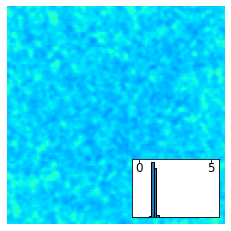

In [5]:
# Plot
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.55, 0.15, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

bins = np.linspace(0,5,31)
ax1.imshow(img/img.mean(), cmap='jet',vmin=0,vmax=3)
ax1.axis('off')
ax2.hist(np.ravel(img)/img.mean(), bins=bins,edgecolor='k')
ax2.set_xlim([-.5,5.5])
ax2.xaxis.set_ticks_position('top')
ax2.tick_params(axis="x",direction="in", pad=-15)
plt.yticks([]); plt.xticks(fontsize=12)
plt.savefig('3C_{}fs_{}_speckle_{}.eps'.format(tpulse,Tmodel, round(contrast,3)))

In [6]:
# I/O
fname = '3C_{}fs_{}_speckle.h5'.format(tpulse,Tmodel)
with h5py.File(fname,'w') as f:
    f.create_dataset('image', data=img/img.mean())
    f.create_dataset('contrast', data=[contrast])
